# Uniswap V2 Simulation
* To download notebook to this tutorial, see [here](https://github.com/defipy-devs/defipy-docs/blob/main/docs/tutorials/univ2_sim.ipynb) 

In [2]:
from defipy import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc
import datetime

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Univariate

### Simulate GBM process

In [21]:
# Instantiation Parameters
n_steps = 500     # Number of steps 
start_price = 10 # Initial price SYS/USD
mu = 0.1; sigma = 0.5
n_paths = 1      # Number of simulationed paths
seconds_year = 31536000

# Brownian Model 
bm = BrownianModel(start_price)
p_arr = bm.gen_gbms(mu, sigma, n_steps-1, n_paths).flatten()

dt = datetime.timedelta(seconds=seconds_year/n_steps)
dates = [datetime.datetime.strptime("2024-09-01", '%Y-%m-%d') + k*dt for k in range(n_steps)]

### Setup UniV2 Pool

In [22]:
user_nm = 'user0'
tkn1_amount = 1000
tkn2_amount = p_arr[0]*tkn1_amount

In [23]:
tkn1_nm = 'TKN1'
tkn2_nm = 'TKN2'

tkn1 = ERC20('TKN1', "0x111")
tkn2 = ERC20('TKN2', "0x09")
exchg_data = UniswapExchangeData(tkn0 = tkn1, tkn1 = tkn2, symbol="LP", address="0x011")

factory = UniswapFactory("pool factory", "0x2")
lp = factory.deploy(exchg_data)
Join().apply(lp, user_nm, tkn1_amount, tkn2_amount)

lp.summary()

Exchange TKN1-TKN2 (LP)
Reserves: TKN1 = 1000.0, TKN2 = 10000.0
Liquidity: 3162.2776601683795 



### Simulation: Random Swapping

In [24]:
arb = CorrectReserves(lp, x0 = p_arr[0])
TKN_amt = TokenDeltaModel(100)
pTKN1_TKN2_arr = []; 

for k in range(n_steps):

    # *****************************
    # ***** Random Swapping ******
    # *****************************
    Swap().apply(lp, tkn1, user_nm, TKN_amt.delta())
    Swap().apply(lp, tkn2, user_nm, p_arr[k]*TKN_amt.delta())
    
    # *****************************
    # ***** Rebalance ******
    # *****************************
    arb.apply(p_arr[k])

    # *****************************
    # ******* Data Capture ********
    # *****************************
    pTKN1_TKN2_arr.append(LPQuote().get_price(lp, tkn1))

lp.summary()

Exchange TKN1-TKN2 (LP)
Reserves: TKN1 = 931.2998693040525, TKN2 = 16330.8976587654
Liquidity: 3740.037906127559 



### Plot Results

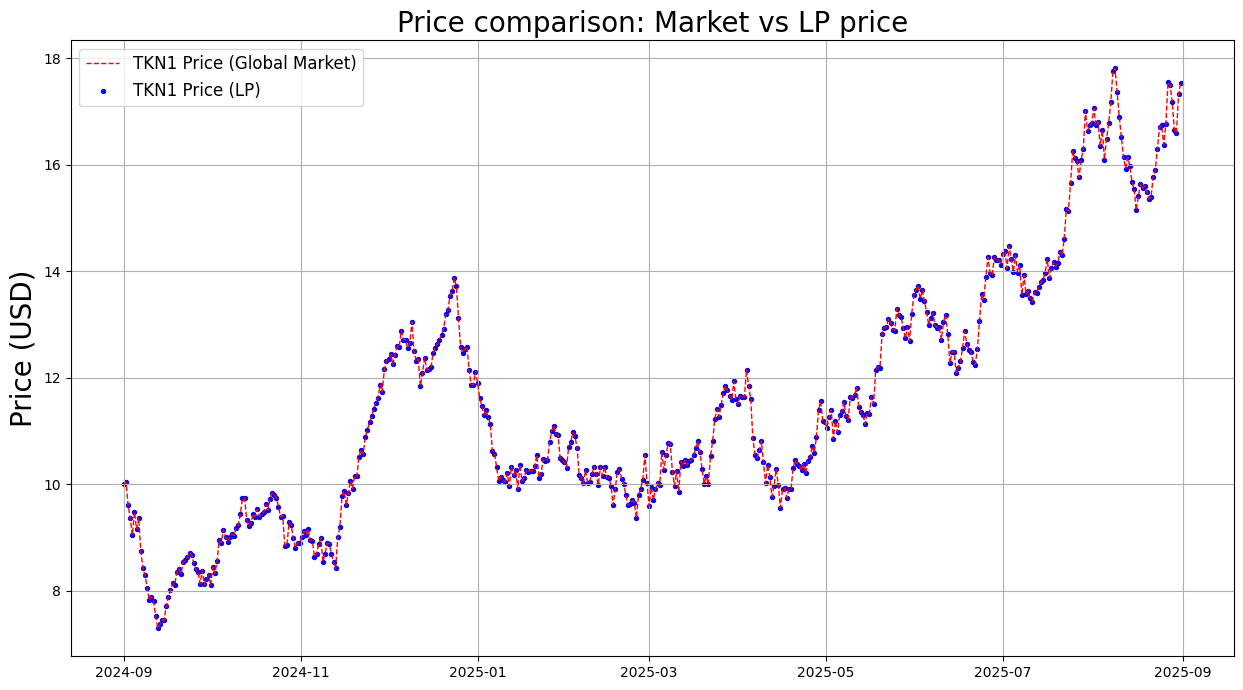

In [25]:
fig, (TKN_ax) = plt.subplots(nrows=1, sharex=False, sharey=False, figsize=(15, 8))

TKN_ax.plot(dates, p_arr, color = 'r',linestyle = 'dashed', linewidth=1, label=f'{tkn1_nm} Price (Global Market)')
TKN_ax.scatter(dates, pTKN1_TKN2_arr, s=10, marker='o', color = 'b',linestyle = '-', linewidth=0.7, label=f'{tkn1_nm} Price (LP)')

TKN_ax.set_title('Price comparison: Market vs LP price', fontsize=20)
TKN_ax.set_ylabel('Price (USD)', size=20)
TKN_ax.legend(fontsize=12)
TKN_ax.grid()

## Multivariate

In [3]:
n_steps = 5000
start_price = 0.1
mu = 0.3; sigma = 0.5
n_paths = 25

b = BrownianModel(start_price)
p_arr = b.gen_gbms(mu, sigma, n_steps, n_paths)
exp_p_arr = np.median(p_arr, axis = 1)

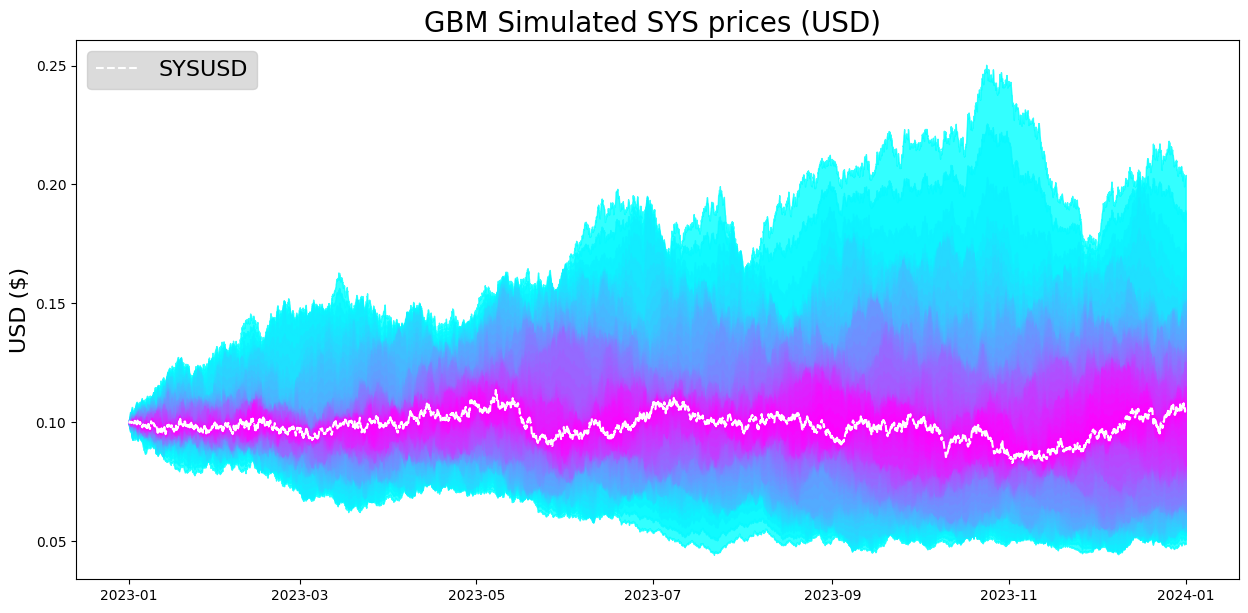

In [4]:
t_deltas = np.linspace(0, 365, num=n_steps+1)
start = datetime.datetime(2023, 1, 1, 0, 0, 0)
date_times = np.array([start + datetime.timedelta(days=t_delta) for t_delta in t_deltas])  

fig = plt.figure(figsize=(15, 7))
USD_ax = fig.gca()

pymc.gp.util.plot_gp_dist( 
    ax=USD_ax,
    x=date_times,
    samples=p_arr.transpose(),
    palette='cool',
    plot_samples=False
)

USD_ax.plot(date_times, exp_p_arr, color = 'white',linestyle = 'dashed', label='SYSUSD') 
USD_ax.set_title("GBM Simulated SYS prices (USD) ", fontsize=20)
USD_ax.set_ylabel("USD ($)", fontsize=16)
USD_ax.legend(fontsize=16, facecolor="lightgray", loc='upper left')

In [5]:
sys_arr = np.zeros((n_steps, n_paths), np.float64)
x_amt_arr = np.zeros((n_steps, n_paths), np.float64)
y_amt_arr = np.zeros((n_steps, n_paths), np.float64)

for k in range(n_paths):
    print(f'Trial run {k}')
    p_trial_arr = p_arr[:,k]
    
    tkn = ERC20('TKN', "0x09")
    dai = ERC20('DAI', "0x111")
    
    lp_sim = SimpleLPSimulation()
    lp_sim.init_amts(10000, p_trial_arr[0])
    lp_sim.create_lp(tkn, dai)
    lp_sim.run(p_trial_arr)
    
    sys_arr[:,k] = lp_sim.get_tkn_price_sim()
    x_amt_arr[:,k] = lp_sim.get_x_amt_sim()
    y_amt_arr[:,k] = lp_sim.get_y_amt_sim()

Trial run 0
Trial run 1
Trial run 2
Trial run 3
Trial run 4
Trial run 5
Trial run 6
Trial run 7
Trial run 8
Trial run 9
Trial run 10
Trial run 11
Trial run 12
Trial run 13
Trial run 14
Trial run 15
Trial run 16
Trial run 17
Trial run 18
Trial run 19
Trial run 20
Trial run 21
Trial run 22
Trial run 23
Trial run 24


Text(0, 0.5, 'DAI')

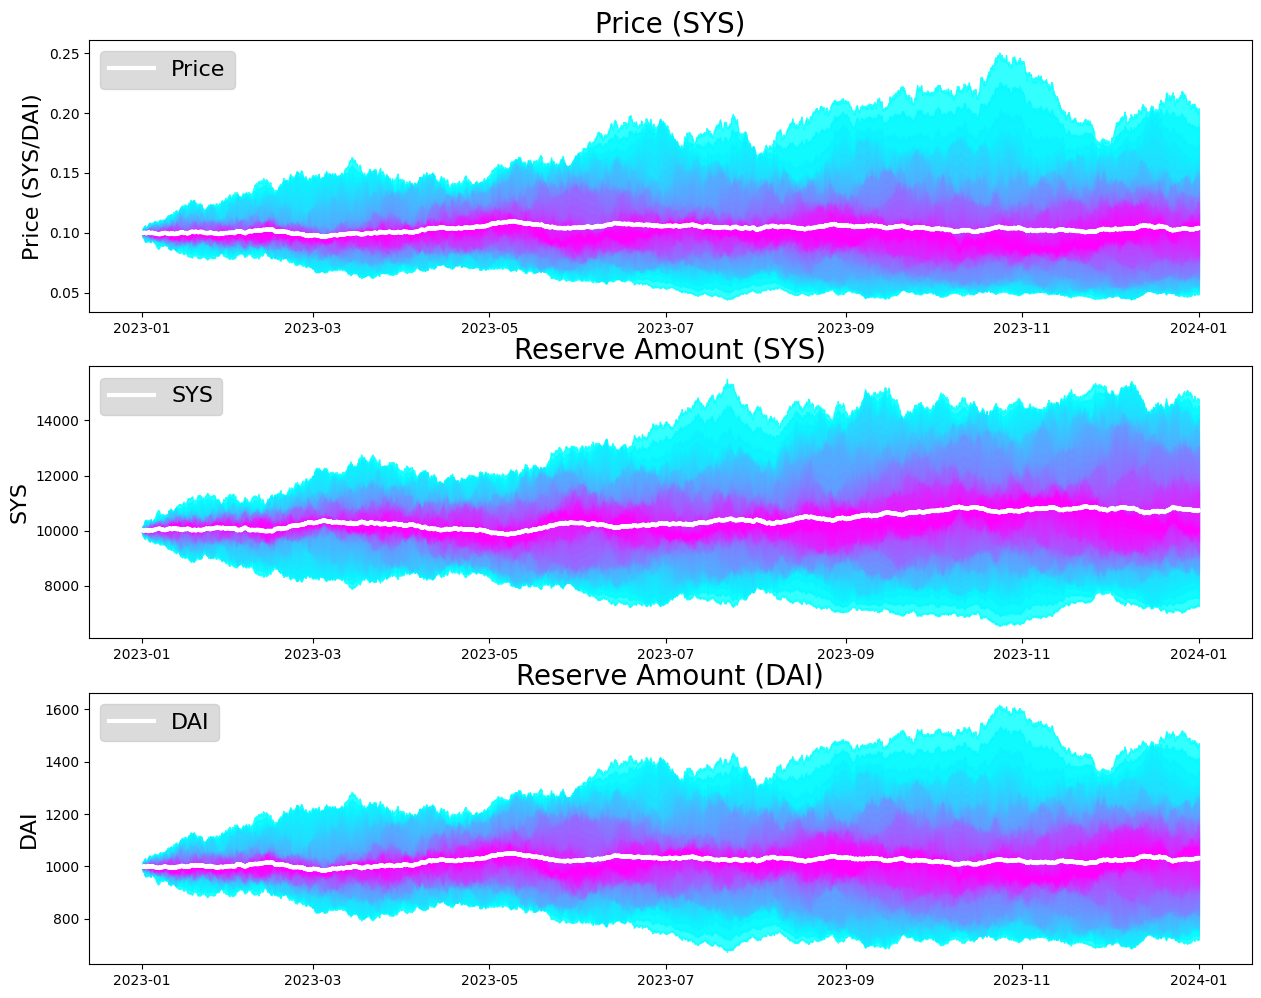

In [6]:
fig, (P_ax, SYS_ax, DAI_ax) = plt.subplots(nrows=3, sharex=False, sharey=False, figsize=(15, 12))

pymc.gp.util.plot_gp_dist( 
    ax=P_ax,
    x=date_times[1:],
    samples=sys_arr.transpose(),
    palette='cool',
    plot_samples=False
)
P_ax.plot(date_times[1:], np.mean(sys_arr, axis = 1), color = 'w', linewidth=3, label='Price')
P_ax.set_title("Price (SYS)", fontsize=20)
P_ax.legend(fontsize=16, facecolor="lightgray", loc='upper left')
P_ax.set_ylabel("Price (SYS/DAI)", fontsize=16)

pymc.gp.util.plot_gp_dist( 
    ax=SYS_ax,
    x=date_times[1:],
    samples=x_amt_arr.transpose(),
    palette='cool',
    plot_samples=False
)
SYS_ax.plot(date_times[1:], np.mean(x_amt_arr, axis = 1), color = 'w', linewidth=3, label='SYS')
SYS_ax.set_title("Reserve Amount (SYS)", fontsize=20)
SYS_ax.legend(fontsize=16, facecolor="lightgray", loc='upper left')
SYS_ax.set_ylabel("SYS", fontsize=16)

pymc.gp.util.plot_gp_dist( 
    ax=DAI_ax,
    x=date_times[1:],
    samples=y_amt_arr.transpose(),
    palette='cool',
    plot_samples=False
)
DAI_ax.plot(date_times[1:], np.mean(y_amt_arr, axis = 1), color = 'w', linewidth=3, label='DAI')
DAI_ax.set_title("Reserve Amount (DAI)", fontsize=20)
DAI_ax.legend(fontsize=16, facecolor="lightgray", loc='upper left')
DAI_ax.set_ylabel("DAI", fontsize=16)